In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from sqlalchemy import create_engine
from config import username, password

engine = create_engine('postgresql://{}:{}@localhost:5432/cali_renewable_db'.format(username,password))
con = engine.connect()

sql_prod = '''Select * From  "Production".hourlyrenewable'''

full_data = pd.read_sql(sql=sql_prod,con=con)
full_data['date'] = pd.to_datetime(full_data['date'])

display(full_data.head())

sql_demand = 'Select * From "Demand".hourlydemand'
demand_data = pd.read_sql(sql=sql_demand, con=con)

demand_data['date'] = pd.to_datetime(demand_data['date'])
demand_data['YEAR'] = demand_data['date'].dt.year

demand_data.head()

,timestamp,date,Hour,TOTAL,SOLAR TOTAL,SOLAR PV,SOLAR THERMAL,WIND TOTAL,GEOTHERMAL,BIOMASS,BIOGAS,SMALL HYDRO
0,2015-06-01 00:00:00,2015-06-01,1,4669,0,0,0,2942,1038,321,209,159
1,2015-06-01 01:00:00,2015-06-01,2,4396,0,0,0,2708,1040,316,210,122
2,2015-06-01 02:00:00,2015-06-01,3,4197,0,0,0,2509,1039,319,209,121
3,2015-06-01 03:00:00,2015-06-01,4,4059,0,0,0,2372,1035,320,209,123
4,2015-06-01 04:00:00,2015-06-01,5,3694,0,0,0,1973,1035,317,208,161


,timestamp,date,Hour,DEMAND,YEAR
0,2019-12-26 10:00:00,2019-12-26,10,25158.0,2019
1,2019-12-26 09:00:00,2019-12-26,9,25454.0,2019
2,2019-12-26 08:00:00,2019-12-26,8,24774.0,2019
3,2019-12-26 07:00:00,2019-12-26,7,23493.0,2019
4,2019-12-26 06:00:00,2019-12-26,6,21718.0,2019


In [2]:
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler

In [22]:
#still messing around with extra regressors 



full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

scaler = StandardScaler()

dd['cap'] = 17000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))
print(y.iloc[0:5].sum())
print(y.iloc[5:8].sum())
dd_train.info()

,ds,y,cap,on_season,off_season,daytime,on_seasonr
0,2015-06-01 00:00:00,8.448700,9.740969,True,False,-0.795932,1
1,2015-06-01 01:00:00,8.388450,9.740969,True,False,-0.795932,1
2,2015-06-01 02:00:00,8.342125,9.740969,True,False,-0.795932,1
3,2015-06-01 03:00:00,8.308692,9.740969,True,False,-0.795932,1
4,2015-06-01 04:00:00,8.214465,9.740969,True,False,-0.795932,1
5,2015-06-01 05:00:00,8.228978,9.740969,True,False,-0.795932,1
6,2015-06-01 06:00:00,8.365905,9.740969,True,False,-0.795932,1
7,2015-06-01 07:00:00,8.716372,9.740969,True,False,-0.795932,1


21015
14148
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 7 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB


In [23]:
model = Prophet(changepoint_range=.65,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.7)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=8)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=8)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



In [24]:
future = model.make_future_dataframe(periods=365*24,freq='1H')
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 20000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)

forcast = model.predict(future)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,on_seasonr,on_seasonr_lower,on_seasonr_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-01 00:00:00,8.373352,9.903488,8.163954,8.741119,8.373352,8.373352,0.065748,0.065748,0.065748,...,0.107829,0.107829,0.107829,0.354174,0.354174,0.354174,0.0,0.0,0.0,8.439100
1,2015-06-01 01:00:00,8.373365,9.903488,8.116788,8.724612,8.373365,8.373365,0.056069,0.056069,0.056069,...,0.107829,0.107829,0.107829,0.351800,0.351800,0.351800,0.0,0.0,0.0,8.429433
2,2015-06-01 02:00:00,8.373377,9.903488,8.113554,8.693389,8.373377,8.373377,0.031092,0.031092,0.031092,...,0.107829,0.107829,0.107829,0.349306,0.349306,0.349306,0.0,0.0,0.0,8.404469
3,2015-06-01 03:00:00,8.373390,9.903488,8.071641,8.673852,8.373390,8.373390,-0.002523,-0.002523,-0.002523,...,0.107829,0.107829,0.107829,0.346712,0.346712,0.346712,0.0,0.0,0.0,8.370867
4,2015-06-01 04:00:00,8.373402,9.903488,8.038794,8.640476,8.373402,8.373402,-0.034383,-0.034383,-0.034383,...,0.107829,0.107829,0.107829,0.344042,0.344042,0.344042,0.0,0.0,0.0,8.339019


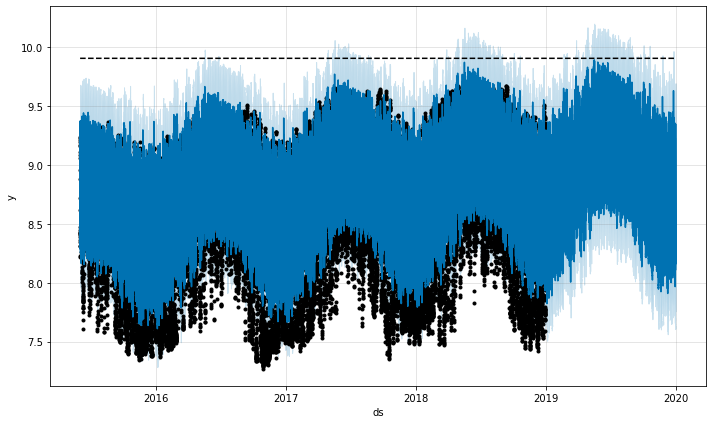

In [25]:
model.plot(forcast)
forcast.head()


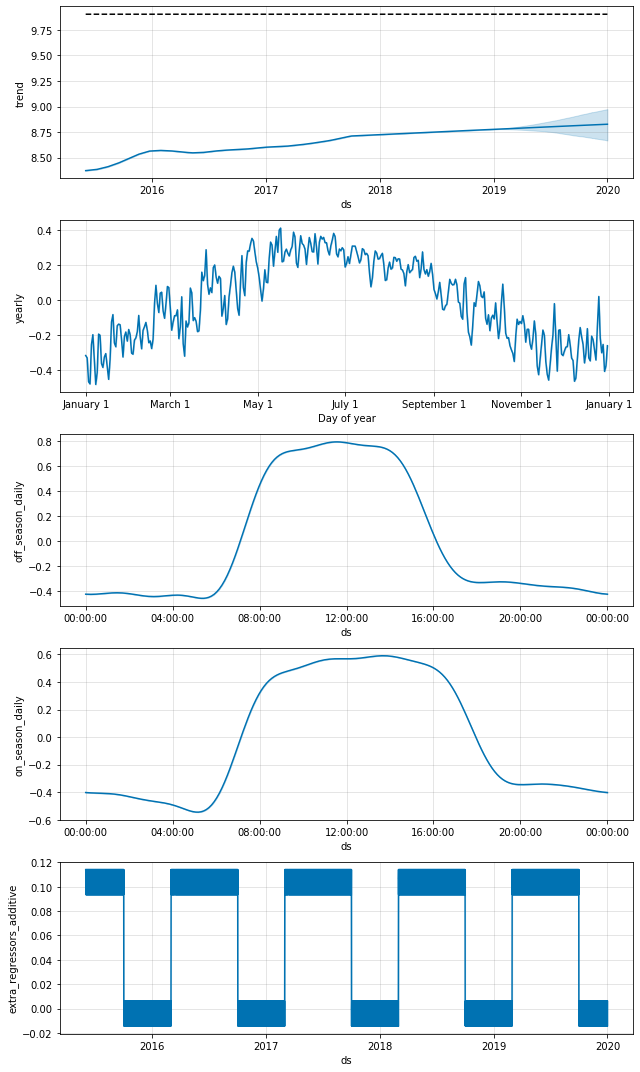

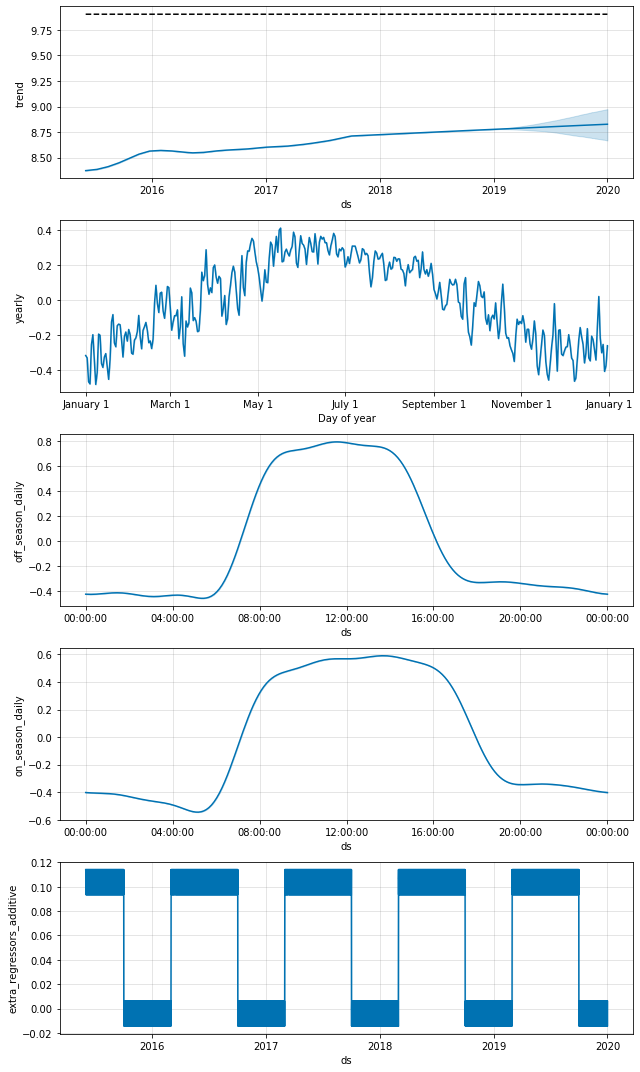

In [26]:
model.plot_components(forcast)

In [27]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

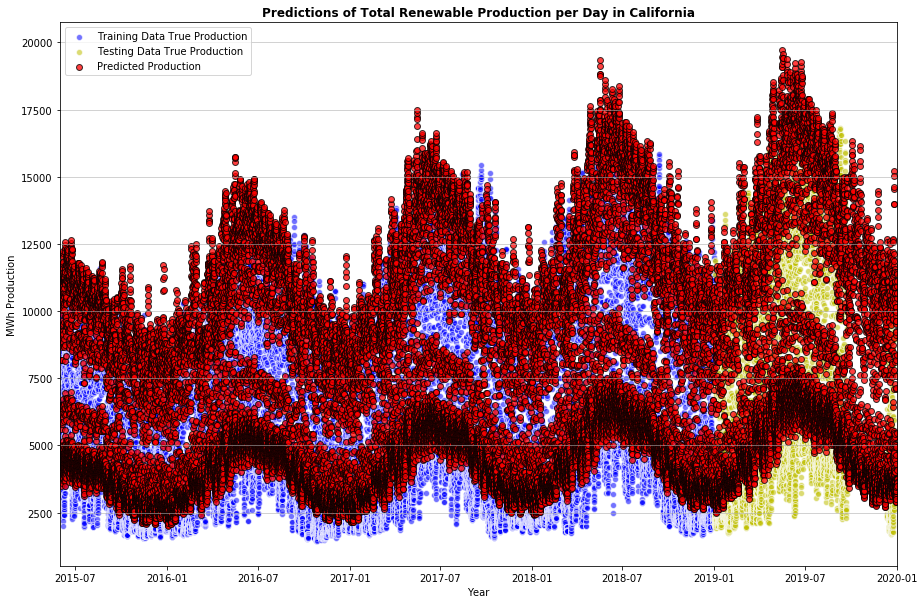

In [28]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  56081.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  7794.0


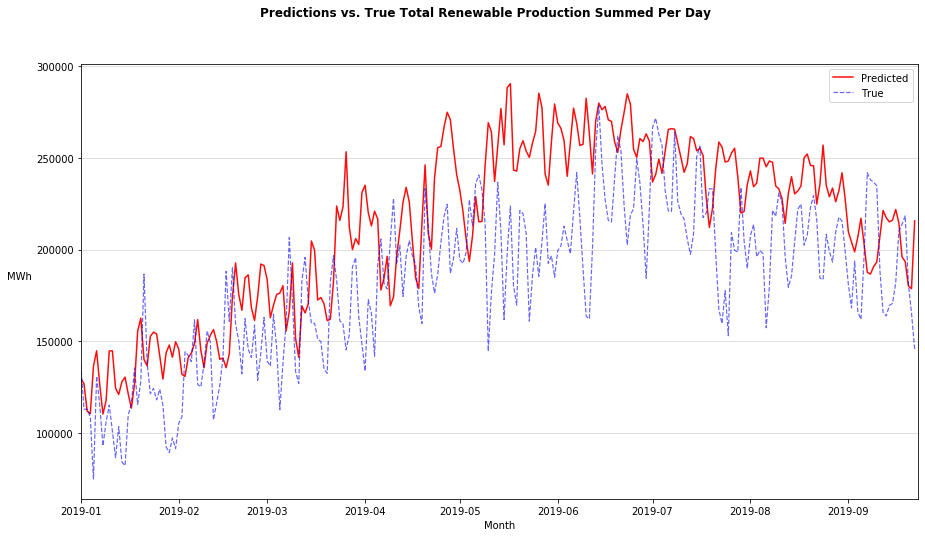

Train MAPE:  25.262894471482973
Train R2:  0.7120670584388157
Test MAPE:  28.621633245896675
Test R2:  0.7197932124997217


In [29]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values



datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'y'].values


month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))

plt.show()

yhat_train = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2014')) & (forcast['ds'] < pd.to_datetime('01/01/2017'))),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014')) & (dd['ds'] < pd.to_datetime('01/01/2017'))),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),(true_train.set_index(pd.DatetimeIndex(true_train['ds']))),how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [31]:
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['SOLAR TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd_s = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month > 3) & (date.month < 11)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1



dd_s.columns = ['ds','y']

scaler = StandardScaler()

dd_s['cap'] = np.cbrt(10000)
#dd_s['cap'] = np.log(dd['cap'])

dd_s['on_season'] = dd_s['ds'].apply(on_season)
dd_s['off_season'] = ~dd_s['ds'].apply(on_season)
dd_s['daytime'] = dd_s['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd_s['on_seasonr'] = dd_s['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
#dd['y'] = dd['y'].replace(0,dd['y'].median())
dd_s['y'] = np.cbrt(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
#dd_s['y'] = np.log(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd_s['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd_s['daytime'] = scaler.fit_transform(daytimev)

dd_s_train = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2014'))&(dd_s['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_s_train.head(8))

dd_s_train.info()

,ds,y,cap,on_season,off_season,daytime,on_seasonr
0,2015-06-01 00:00:00,0.000000,21.544347,True,False,-0.795932,1
1,2015-06-01 01:00:00,0.000000,21.544347,True,False,-0.795932,1
2,2015-06-01 02:00:00,0.000000,21.544347,True,False,-0.795932,1
3,2015-06-01 03:00:00,0.000000,21.544347,True,False,-0.795932,1
4,2015-06-01 04:00:00,0.000000,21.544347,True,False,-0.795932,1
5,2015-06-01 05:00:00,0.000000,21.544347,True,False,-0.795932,1
6,2015-06-01 06:00:00,8.494807,21.544347,True,False,-0.795932,1
7,2015-06-01 07:00:00,13.787611,21.544347,True,False,-0.795932,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 7 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB


In [32]:
model = Prophet(changepoint_range=.55,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.7)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=8)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=8)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_s_train)



In [33]:
futures = model.make_future_dataframe(periods=365*24,freq='1H')
futures['on_season'] = futures['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
futures['off_season'] = ~futures['ds'].apply(on_season)
futures['daytime'] = futures['ds'].apply(daytime)
futures['on_seasonr'] = futures['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
futures['cap'] = np.cbrt(11000)
#futures['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = futures['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
futures['daytime'] = scaler.fit_transform(daytimef)

forcasts = model.predict(futures)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,on_seasonr,on_seasonr_lower,on_seasonr_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
40147,2019-12-31 19:00:00,10.212074,22.239801,-1.791739,2.819097,9.774101,10.659737,-9.737370,-9.737370,-9.737370,...,0.0,0.0,0.0,-3.471449,-3.471449,-3.471449,0.0,0.0,0.0,0.474704
40148,2019-12-31 20:00:00,10.212095,22.239801,-2.385297,2.427690,9.774043,10.659825,-10.284230,-10.284230,-10.284230,...,0.0,0.0,0.0,-3.465197,-3.465197,-3.465197,0.0,0.0,0.0,-0.072134
40149,2019-12-31 21:00:00,10.212117,22.239801,-2.367094,2.356693,9.773984,10.659914,-10.250694,-10.250694,-10.250694,...,0.0,0.0,0.0,-3.455478,-3.455478,-3.455478,0.0,0.0,0.0,-0.038577
40150,2019-12-31 22:00:00,10.212138,22.239801,-2.239546,2.563493,9.773925,10.660003,-10.041131,-10.041131,-10.041131,...,0.0,0.0,0.0,-3.442459,-3.442459,-3.442459,0.0,0.0,0.0,0.171007
40151,2019-12-31 23:00:00,10.212159,22.239801,-2.477298,2.144638,9.773866,10.660092,-10.397659,-10.397659,-10.397659,...,0.0,0.0,0.0,-3.426338,-3.426338,-3.426338,0.0,0.0,0.0,-0.185500


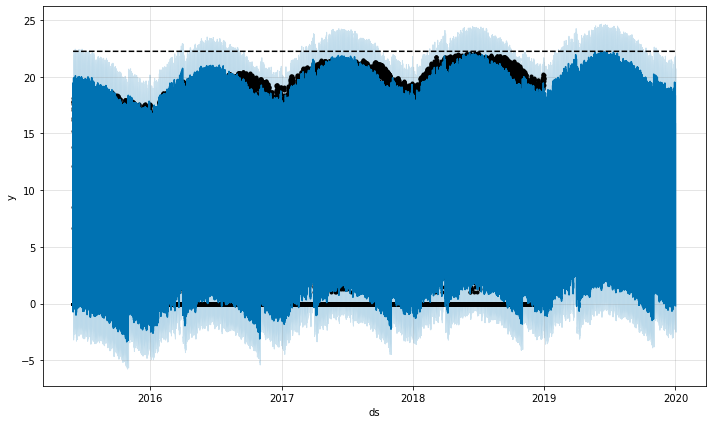

In [34]:
model.plot(forcasts)
forcasts.tail()

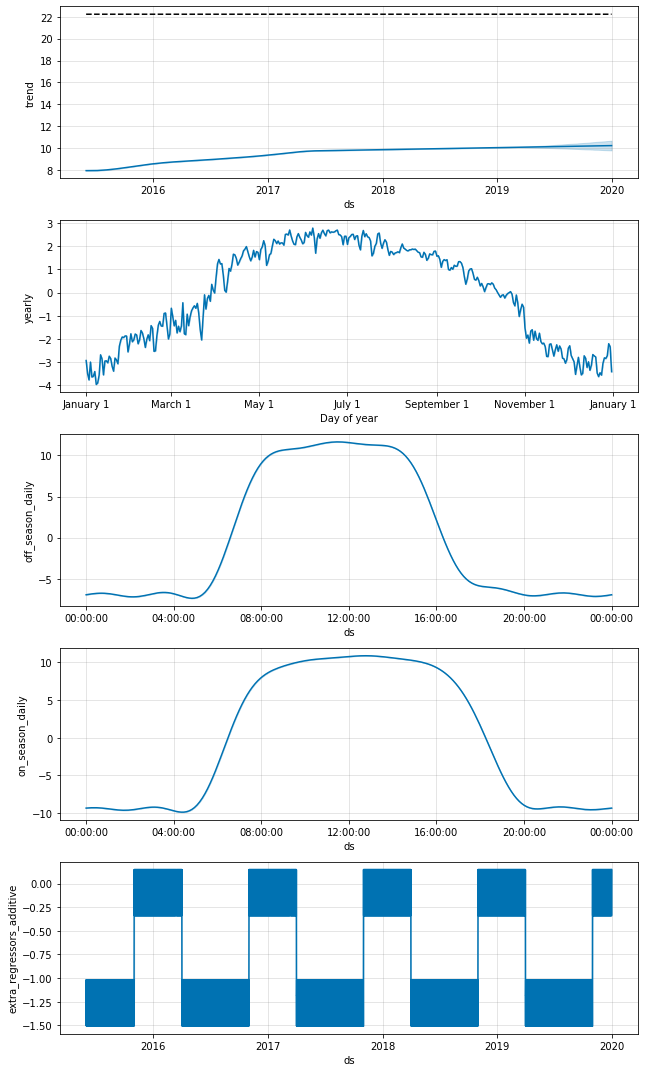

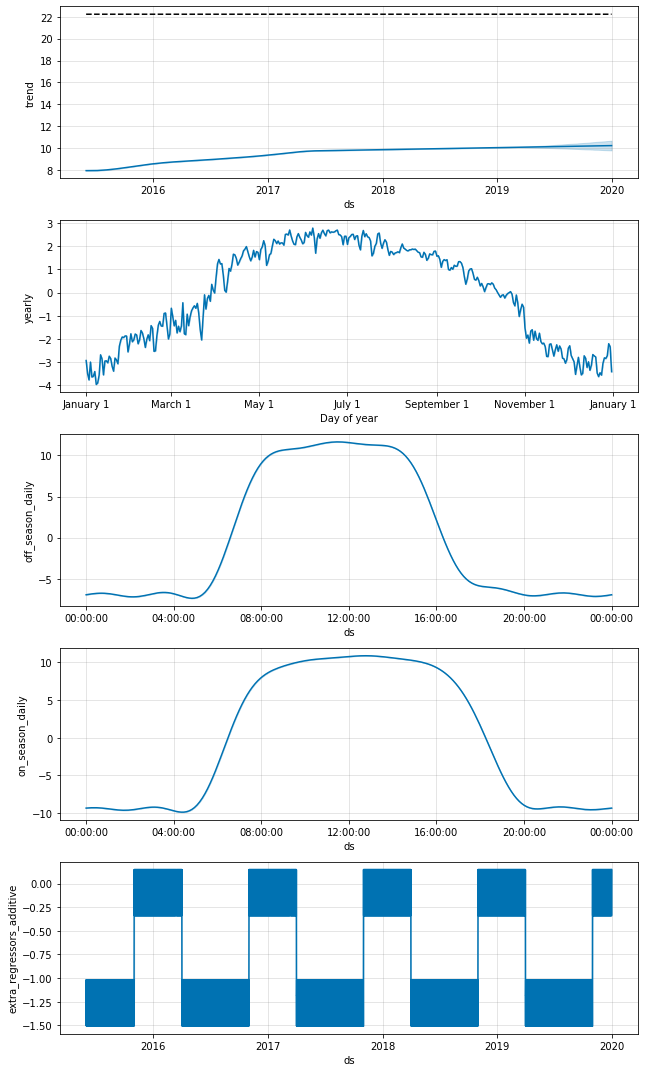

In [35]:
model.plot_components(forcasts)

In [37]:
#dd_s['y'] = np.exp(dd['y'])
dd_s['y'] = (dd_s['y'])**3
#dd_s_train['y'] = np.exp(dd_s_train['y'])
dd_s_train['y'] = (dd_s_train['y'])**3
#forcasts['yhst'] = np.exp(forcast['yhat'])
forcasts['yhat'] = (forcasts['yhat'])**3
dd_s_test = dd_s.loc[dd_s['ds']>pd.to_datetime('01/01/2019')]

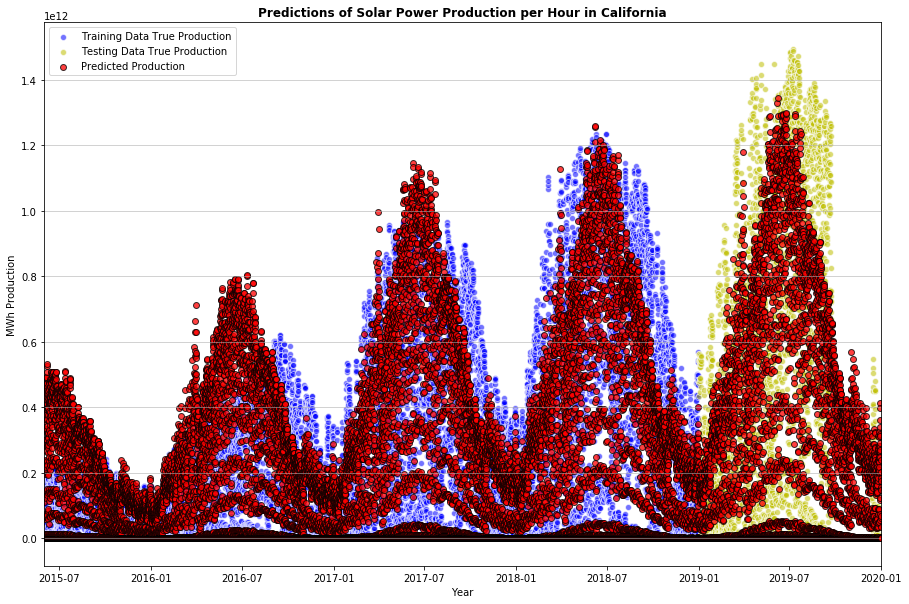

In [38]:

plt.figure(figsize=(15,10))

plt.scatter(dd_s_train['ds'],dd_s_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_s_test['ds'],dd_s_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcasts['ds'],forcasts['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.show()

Predicted total solar Production 2017:  1417453123976.0
True total solar Production 2017:  1752432116056.0
Error in year total prediction in GWh:  -334978992080.0


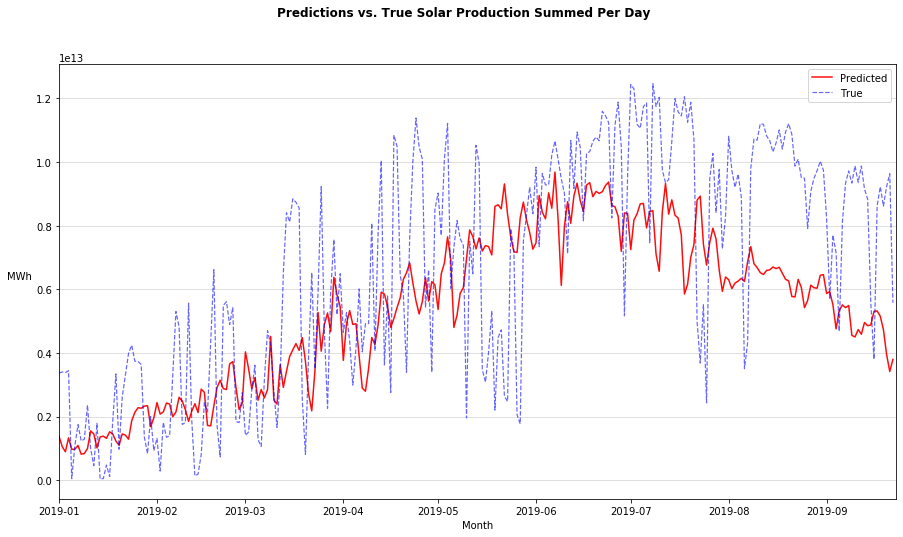

Test MAPE:  inf
Train R2:  0.7629753561504176
Test MAPE:  inf
Test R2:  0.7629753561504176


C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning:

divide by zero encountered in double_scalars



In [41]:
yhats = pd.DataFrame(forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (forcasts['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
trues = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (dd_s['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

testers = pd.merge(yhats.set_index(pd.DatetimeIndex(yhats['ds'])),(trues.set_index(pd.DatetimeIndex(trues['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted total solar Production 2017: ',(testers['yhat'].sum())//1000)
print('True total solar Production 2017: ',testers['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (testers['yhat'].sum()-testers['y'].sum())//1000)


datafs = forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                       (forcasts['ds'] < pd.to_datetime('09/23/2019'))),:].\
set_index(pd.DatetimeIndex(forcasts.loc[((forcasts['ds'] >= pd.to_datetime\
                                          ('01/01/2019')) & (forcasts['ds'] \
                                                             < pd.to_datetime\
                                                             ('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values



datats = dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                   (dd_s['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd_s['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'y'].values

month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,datafs,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datats,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Solar Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
#plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_trains = pd.DataFrame(forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                                         (forcasts['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true_trains = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                                     (dd_s['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester_trains = pd.merge(yhat_trains.set_index(pd.DatetimeIndex(yhat_trains['ds'])),(true_trains.set_index(pd.DatetimeIndex(true_trains['ds']))),how='left',left_index=True,right_index=True)


tester_trains['msem'] = ((tester_trains['y']-tester_trains['yhat'])**2)
tester_trains['mseb'] = (tester_trains['y']-tester_trains['y'].mean())**2
r2 = 1 - ((np.sum(tester_trains['msem'])/len(tester_trains))/(np.sum(tester_trains['mseb'])/len(tester_trains)))
true_trains = tester_trains['y'].values
yhat_trains = tester_trains['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_trains,yhat_trains)))*(100/len(true_trains))
print('Test MAPE: ', mape)
print('Train R2: ',r2)


testers['msem'] = ((testers['y']-testers['yhat'])**2)
testers['mseb'] = (testers['y']-testers['y'].mean())**2
r2 = 1 - ((np.sum(testers['msem'])/len(testers))/(np.sum(testers['mseb'])/len(testers)))
true_tests = testers['y'].values
yhat_tests = testers['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_tests,yhat_tests)))))*100)/len(true_tests)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [80]:
 
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']

daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

dd_sm = forcasts.loc[:,['ds','yhat']]
print('''forcasts.loc[:,['ds','yhat']].head()''')
display(forcasts.loc[:,['ds','yhat']].head())

dd = pd.merge(dd.set_index(pd.DatetimeIndex(dd['ds'])),(dd_sm.set_index(pd.DatetimeIndex(dd_sm['ds']))),
              how='left',left_index=True,right_index=True)
dd = dd.reset_index()
dd.drop(columns=['ds_x','ds_y'],inplace=True)
dd.columns = ['ds','y','solar']
display(dd.head())


scaler = StandardScaler()

dd['cap'] = 25000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_seasonr'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

solarv = dd['solar'].values
solarv = solarv.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)
dd['solar'] = scaler.fit_transform(solarv)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

forcasts.loc[:,['ds','yhat']].head()


,ds,yhat
0,2015-06-01 00:00:00,-0.000192
1,2015-06-01 01:00:00,-0.001228
2,2015-06-01 02:00:00,-0.017861
3,2015-06-01 03:00:00,-0.000005
4,2015-06-01 04:00:00,-0.061160


,ds,y,solar
0,2015-06-01 00:00:00,4669,-0.000192
1,2015-06-01 01:00:00,4396,-0.001228
2,2015-06-01 02:00:00,4197,-0.017861
3,2015-06-01 03:00:00,4059,-0.000005
4,2015-06-01 04:00:00,3694,-0.061160


,ds,y,solar,cap,on_season,off_season,daytime,on_seasonr
0,2015-06-01 00:00:00,8.448700,-0.579870,10.126631,True,False,-0.795932,1
1,2015-06-01 01:00:00,8.388450,-0.579870,10.126631,True,False,-0.795932,1
2,2015-06-01 02:00:00,8.342125,-0.579870,10.126631,True,False,-0.795932,1
3,2015-06-01 03:00:00,8.308692,-0.579870,10.126631,True,False,-0.795932,1
4,2015-06-01 04:00:00,8.214465,-0.579870,10.126631,True,False,-0.795932,1
5,2015-06-01 05:00:00,8.228978,-0.579870,10.126631,True,False,-0.795932,1
6,2015-06-01 06:00:00,8.365905,-0.579857,10.126631,True,False,-0.795932,1
7,2015-06-01 07:00:00,8.716372,-0.546326,10.126631,True,False,-0.795932,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 8 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
solar         31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(4), int64(1)
memory usage: 1.7 MB


In [62]:
model = Prophet(changepoint_range=.45,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.52)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=4)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=6)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
model.add_regressor('solar')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



In [86]:
future = model.make_future_dataframe(periods=365*24,freq='1H')

dd_smf = forcasts.loc[:,['ds','yhat']]

future = pd.merge(future.set_index(pd.DatetimeIndex(future['ds'])),(dd_smf.set_index(pd.DatetimeIndex(dd_smf['ds']))),how='left',left_index=True,right_index=True)
future = future.reset_index()
future.drop(columns=['ds_x','ds_y'],inplace=True)

future.info()
future.loc[(future['ds'] > pd.to_datetime('09/23/2019'))&(future['ds']< pd.to_datetime('12/16/2019'))].tail(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40152 entries, 0 to 40151
Data columns (total 2 columns):
ds      40152 non-null datetime64[ns]
yhat    40152 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 627.5 KB


,ds,yhat
39668,2019-12-11 20:00:00,9.154860e-09
39669,2019-12-11 21:00:00,2.605674e-07
39670,2019-12-11 22:00:00,3.788542e-04
39671,2019-12-11 23:00:00,1.240772e-10
39672,2019-12-12 00:00:00,1.218513e-05
39673,2019-12-12 01:00:00,9.841848e-04
39674,2019-12-12 02:00:00,2.422214e-09
39675,2019-12-12 03:00:00,1.496717e-03
39676,2019-12-12 04:00:00,4.560554e-03
39677,2019-12-12 05:00:00,6.643934e-11


In [88]:
future.rename(columns={
    'yhat':'solar'
}, inplace=True)
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 25000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

solarf = future['solar'].values
solarf = solarf.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)
future['solar'] = scaler.fit_transform(solarf)

display(future.head())


,ds,solar,on_season,off_season,daytime,on_seasonr,cap
0,2015-06-01 00:00:00,-0.579462,True,False,-0.795932,1,10.126631
1,2015-06-01 01:00:00,-0.579462,True,False,-0.795932,1,10.126631
2,2015-06-01 02:00:00,-0.579462,True,False,-0.795932,1,10.126631
3,2015-06-01 03:00:00,-0.579462,True,False,-0.795932,1,10.126631
4,2015-06-01 04:00:00,-0.579462,True,False,-0.795932,1,10.126631


In [89]:
forcast = model.predict(future)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,solar,solar_lower,solar_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
40147,2019-12-31 19:00:00,8.778853,10.126631,7.765002,8.490340,8.520586,8.965841,-0.621266,-0.621266,-0.621266,...,0.025329,0.025329,0.025329,-0.327141,-0.327141,-0.327141,0.0,0.0,0.0,8.157587
40148,2019-12-31 20:00:00,8.778863,10.126631,7.758080,8.488255,8.520546,8.965885,-0.629583,-0.629583,-0.629583,...,0.025329,0.025329,0.025329,-0.328936,-0.328936,-0.328936,0.0,0.0,0.0,8.149279
40149,2019-12-31 21:00:00,8.778872,10.126631,7.671677,8.454782,8.520506,8.965929,-0.669678,-0.669678,-0.669678,...,0.025329,0.025329,0.025329,-0.330934,-0.330934,-0.330934,0.0,0.0,0.0,8.109194
40150,2019-12-31 22:00:00,8.778881,10.126631,7.662145,8.439377,8.520466,8.965973,-0.692086,-0.692086,-0.692086,...,0.025329,0.025329,0.025329,-0.333107,-0.333107,-0.333107,0.0,0.0,0.0,8.086795
40151,2019-12-31 23:00:00,8.778891,10.126631,7.681897,8.456525,8.520426,8.966017,-0.697134,-0.697134,-0.697134,...,0.025329,0.025329,0.025329,-0.335424,-0.335424,-0.335424,0.0,0.0,0.0,8.081756


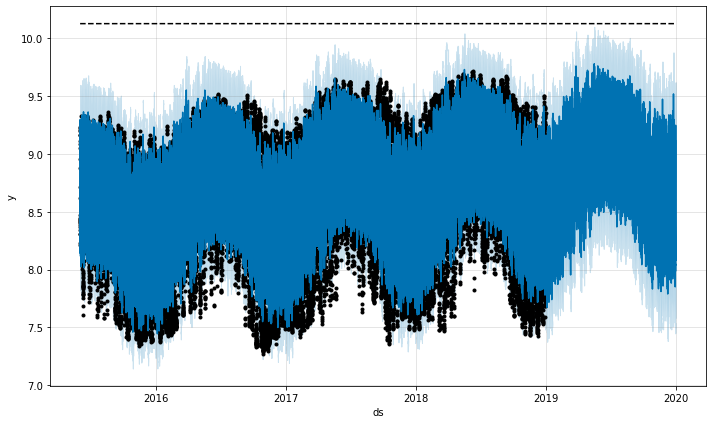

In [90]:
model.plot(forcast)
forcast.tail()

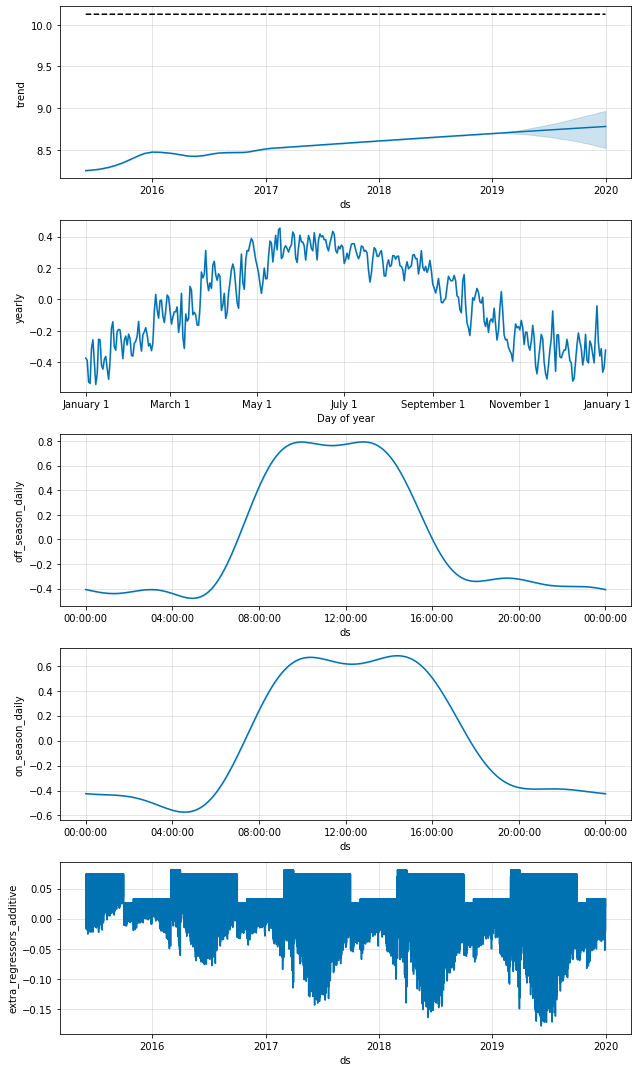

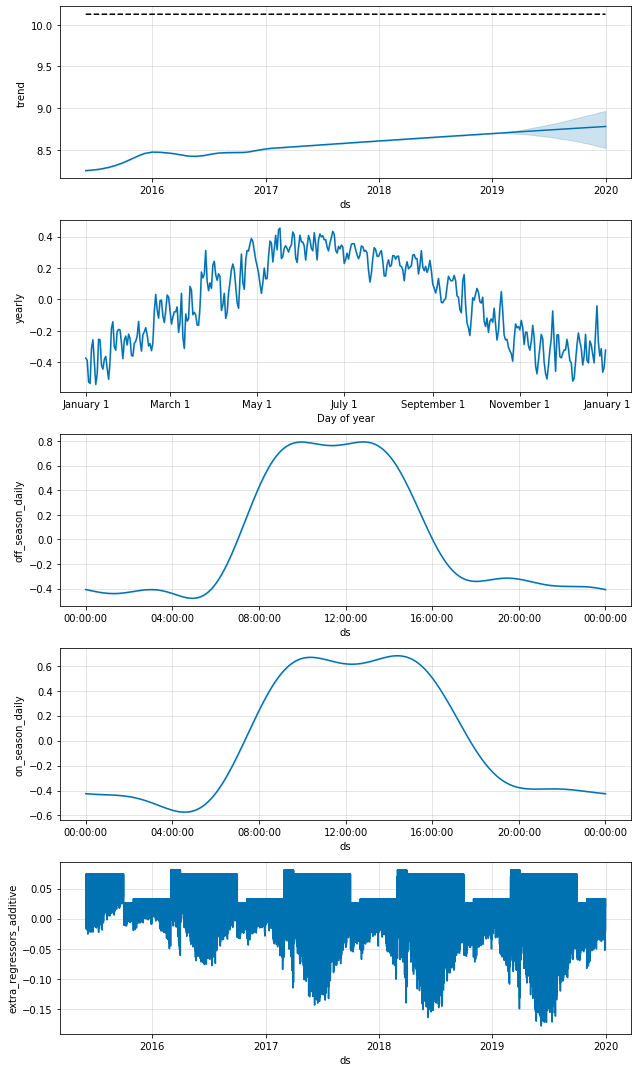

In [91]:
model.plot_components(forcast)

In [92]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

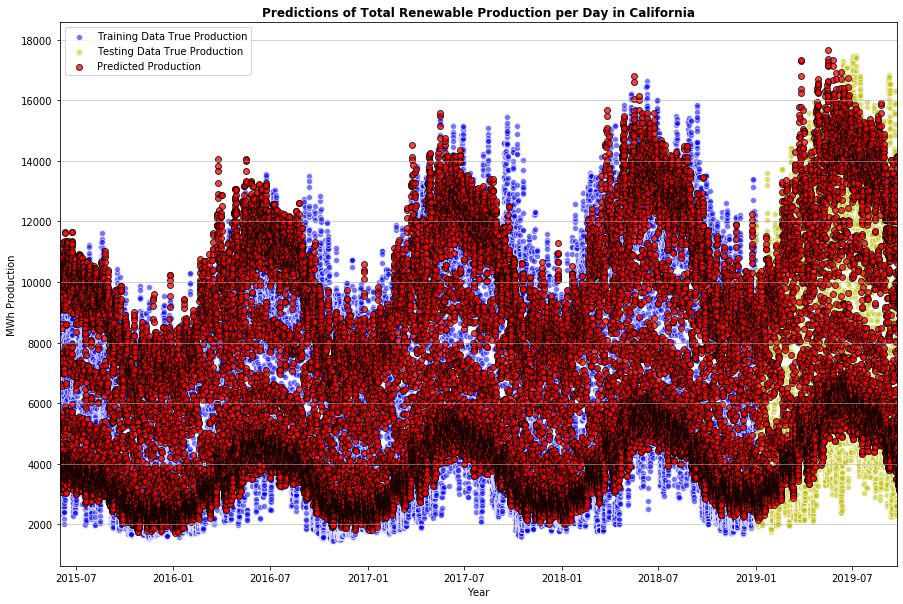

In [93]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  49675.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  1388.0


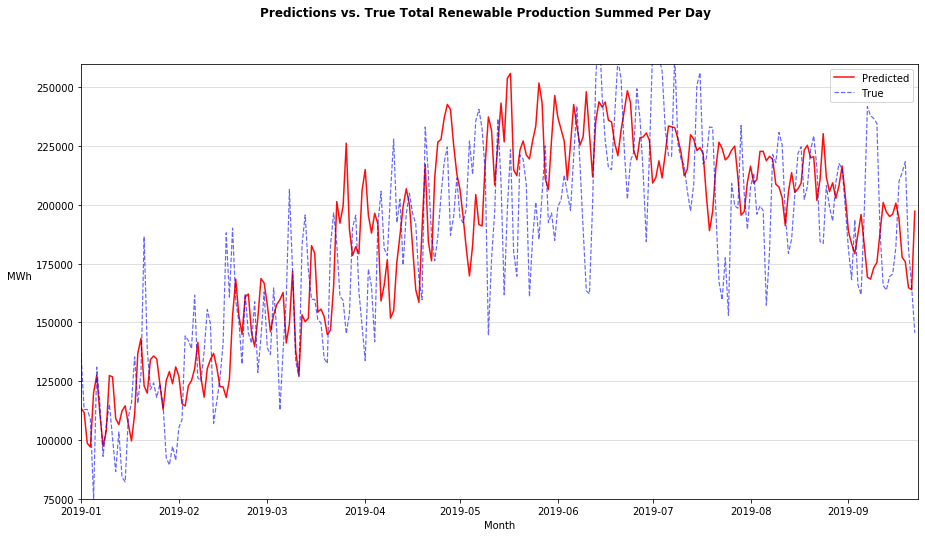

Test MAPE:  21.983798354131874
Train R2:  0.824261373266471
Test MAPE:  21.983798354131874
Test R2:  0.824261373266471


In [94]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'yhat'].values


datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('24H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_train = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                       (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                                  (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Test MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [100]:
forcast['solar'] = np.exp(forcast['solar'])
predictions = forcast.loc[:,['ds','solar','yhat']]
predictions.rename(columns={
    'ds':'timestamp',
    'solar':'Pred Solar Prod',
    'yhat':'Pred Tot Renew Prod'
}, inplace=True)
predictions['Hour'] = predictions['timestamp'].dt.hour
predictions = predictions[['timestamp','Hour','Pred Tot Renew Prod','Pred Solar Prod']]
predictions.head()

,timestamp,Hour,Pred Tot Renew Prod,Pred Solar Prod
0,2015-06-01 00:00:00,0,3987.466872,1.156349e+07
1,2015-06-01 01:00:00,1,3942.481507,1.156349e+07
2,2015-06-01 02:00:00,2,3875.858595,1.156349e+07
3,2015-06-01 03:00:00,3,3691.128209,1.156349e+07
4,2015-06-01 04:00:00,4,3458.197482,1.156349e+07


In [101]:
name = 'hourlyrenewablepredictions'
schema = 'Predictions'

predictions.to_sql(name=name, con=con, schema=schema, if_exists='replace',index=False)

In [104]:
with engine.connect() as c:
    c.execute('''ALTER TABLE "Predictions".hourlyrenewablepredictions 
    ADD PRIMARY KEY ("timestamp")''')